In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy    as np
import os.path
import pandas   as pd
import random   as rand
import seaborn  as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# configuration
fulldata2015_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2015.xlsx'
fulldata2016_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2016.xlsx'

In [3]:
rentals2015_df_orig = pd.read_excel(fulldata2015_filepath)
rentals2016_df_orig = pd.read_excel(fulldata2016_filepath)

In [4]:
rentals2015_df = rentals2015_df_orig.copy()
rentals2016_df = rentals2016_df_orig.copy()

rentals = pd.concat([rentals2015_df, rentals2016_df])

In [5]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861322 entries, 0 to 1017370
Data columns (total 6 columns):
L.p.              int64
Numer roweru      int64
Data wynajmu      datetime64[ns]
Data zwrotu       datetime64[ns]
Stacja wynajmu    object
Stacja zwrotu     object
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 99.4+ MB


In [6]:
rentals.head(10)

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
0,1,57735,2015-04-28 11:49:20,2015-04-28 11:49:39,Plac Uniwersytecki,Plac Uniwersytecki
1,2,57735,2015-04-28 11:51:00,2015-04-28 11:52:05,Plac Uniwersytecki,Plac Uniwersytecki
2,3,57735,2015-04-28 11:52:39,2015-04-28 11:54:33,Plac Uniwersytecki,Plac Uniwersytecki
3,4,57735,2015-04-28 11:55:16,2015-04-28 11:56:20,Plac Uniwersytecki,Plac Uniwersytecki
4,5,57047,2015-04-28 11:56:07,2015-04-28 11:57:10,Plac Uniwersytecki,Plac Uniwersytecki
5,6,57129,2015-04-28 11:58:52,2015-04-28 12:17:15,Rondo Reagana,Rondo Reagana
6,7,57505,2015-04-28 12:01:45,2015-04-28 12:06:00,Gliniana - Gajowa,Gliniana - Gajowa
7,8,57700,2015-04-28 12:01:49,2015-04-28 12:09:45,Zachodnia - Poznańska,Plac Strzegomski
8,9,57487,2015-04-28 12:05:13,2015-04-28 12:12:20,Grochowa - Jemiołowa,Grochowa - Jemiołowa
9,10,57681,2015-04-28 12:05:13,2015-04-28 12:15:54,Muzeum Narodowe,Muzeum Narodowe


In [7]:
rentals.isnull().sum()

L.p.              0
Numer roweru      0
Data wynajmu      0
Data zwrotu       0
Stacja wynajmu    0
Stacja zwrotu     0
dtype: int64

In [8]:
rentals.describe()

,L.p.,Numer roweru
count,1.861322e+06,1.861322e+06
mean,4.693704e+05,5.741074e+04
std,2.755368e+05,2.375982e+02
min,1.000000e+00,5.700000e+04
25%,2.326660e+05,5.720300e+04
50%,4.653310e+05,5.740900e+04
75%,6.979960e+05,5.761800e+04
max,1.017371e+06,5.786900e+04


# Data cleaning

### Records with 0s of bike rental time length

In [9]:
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

# Rentals with duration 0 seconds are considered as incorrect, thus will be deleted
rentals2015_df.drop(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ].index, inplace=True)
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

Number of rentals (in 2015) with duration 0 seconds: 47
Number of rentals (in 2016) with duration 0 seconds: 176
Data cleaning verification:
Number of rentals (in 2015) with duration 0 seconds: 0
Number of rentals (in 2016) with duration 0 seconds: 0


### One-hour time shift at the end of Daylight Saving Time (DST)

The Daylight Saving Time change took place in Poland on:
* 2015-03-29 (2:00am => 3:00 am)
* 2015-10-25 (3:00am => 2:00 am)
* 2016-03-27 (2:00am => 3:00 am)
* 2016-10-30 (3:00am => 2:00 am)

#### Year 2015

##### 3:00am -> 2:00am

In [10]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & \
      (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"])
rentals2015_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
787264,787265,57490,2015-10-25 02:23:55,2015-10-25 02:21:33,Rynek,Dworzec Mikołajów
787266,787267,57257,2015-10-25 02:26:04,2015-10-25 02:21:47,Rynek,Dworzec Mikołajów
787281,787282,57167,2015-10-25 02:39:30,2015-10-25 02:12:04,Plac Grunwaldzki - Polaka,Świdnicka - Chrobry
787293,787294,57070,2015-10-25 02:59:10,2015-10-25 02:11:12,Plac Uniwersytecki,Sienkiewicza - Piastowska
787294,787295,57427,2015-10-25 02:59:43,2015-10-25 02:07:00,Arkady,Sky Tower


In [11]:
rentals2015_df.loc[idx, ["Data zwrotu"]] = rentals2015_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2015_df[ (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & 
                                                               (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"]) ])))

Data cleaning verification:
Number of falsy records: 0


In [12]:
# another invalid records
print("Number of falsy records: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"] ])))

Number of falsy records: 0


#### Year 2016

##### 3:00am -> 2:00am

In [13]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
      (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
      (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
979885,979886,57378,2016-10-30 02:59:58,2016-10-30 02:05:56,Dworzec Mikołajów,Dworzec Mikołajów
979887,979888,57666,2016-10-30 02:57:10,2016-10-30 02:07:34,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979888,979889,57680,2016-10-30 02:56:29,2016-10-30 02:08:54,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979889,979890,57783,2016-10-30 02:58:25,2016-10-30 02:14:12,Sienkiewicza - Wyszyńskiego,Sienkiewicza - Wyszyńskiego


In [14]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df.loc[  (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
                                                                    (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
                                                                    (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])  ])))

Data cleaning verification:
Number of falsy records: 0


##### 2:00am -> 3:00am

In [15]:
# bikes rented right before time shift from 2:00am to 3:00am
idx = (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00')
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
35640,35641,57075,2016-03-27 01:51:31,2016-03-27 03:01:13,Kredka i Ołówek,Kredka i Ołówek
35641,35642,57778,2016-03-27 01:51:21,2016-03-27 03:01:23,Żmigrodzka / Kasprowicza,Żmigrodzka / Kasprowicza
35642,35643,57580,2016-03-27 01:55:16,2016-03-27 03:06:22,Armii Krajowej - Borowska,Armii Krajowej - Borowska


In [16]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=-1))

In [17]:
print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & 
                                                               (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00') ])))

Data cleaning verification:
Number of falsy records: 0


In [18]:
# another invalid records
rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
299038,299039,57222,2016-05-25 14:30:32,2016-05-25 14:30:30,Sky Tower,Sky Tower
725195,725196,57689,2016-08-16 11:00:37,2016-08-16 11:00:33,Powstańców Śląskich - Hallera,Powstańców Śląskich - Hallera
725576,725577,57213,2016-08-16 13:19:26,2016-08-16 13:19:24,Rynek,Rynek


In [19]:
# Rentals with negative duration time are considered as incorrect, thus will be deleted
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"] ])))

Data cleaning verification:
Number of falsy records: 0


# Data analysis

## Rental Seasons

In [20]:
def get_season_start_date_and_end_date(df):
    index_first = 0
    index_last  = df.index[-1]

    start_date = df.loc[index_first, "Data wynajmu"].date()
    end_date   = df.loc[index_last, "Data zwrotu"].date()
    return start_date, end_date

rentals2015_start_date, rentals2015_end_date = get_season_start_date_and_end_date(rentals2015_df)
print('Season 2015 started on: ', rentals2015_start_date)
print('Season 2015 ended on:   ', rentals2015_end_date)

rentals2016_start_date, rentals2016_end_date = get_season_start_date_and_end_date(rentals2016_df)
print('Season 2016 started on: ', rentals2016_start_date)
print('Season 2016 ended on:   ', rentals2016_end_date)

Season 2015 started on:  2015-04-28
Season 2015 ended on:    2015-11-30
Season 2016 started on:  2016-03-01
Season 2016 ended on:    2016-11-30


## Number of available bikes

In [21]:
unique_bikes_2015 = len(rentals2015_df["Numer roweru"].unique())
unique_bikes_2016 = len(rentals2016_df["Numer roweru"].unique())

unique_bikes_yoy_2015_2016 = (unique_bikes_2016-unique_bikes_2015)*100/unique_bikes_2015

print('Number of bikes in 2015: {}'.format(unique_bikes_2015))
print('Number of bikes in 2016: {} (change: {:.2f}% year-over-year)'.format(unique_bikes_2016, unique_bikes_yoy_2015_2016))

Number of bikes in 2015: 806
Number of bikes in 2016: 783 (change: -2.85% year-over-year)


**DATA INTERPRETATION**: This is interesting, the numer of bikes that were used in 2016 slightly decreased compared to 2015. City bikes are not popular in Wrocław? Luckily, this is not the downward trend, as the number of bikes increased up to 820 in [2018](https://wroclawskirower.pl/en/).

## Number of rentals

In [22]:
total_rentals_2015 = rentals2015_df.shape[0]
total_rentals_2016 = rentals2016_df.shape[0]

total_rentals_yoy_2015_2016 = (total_rentals_2016-total_rentals_2015)*100/total_rentals_2015

print('Number of all rentals in 2015: {}'.format(total_rentals_2015))
print('Number of all rentals in 2016: {} (change: {:.2f}% year-over-year)'.format(total_rentals_2016, total_rentals_yoy_2015_2016))

Number of all rentals in 2015: 843904
Number of all rentals in 2016: 1017192 (change: 20.53% year-over-year)


## Length of time of bike rental

### 2015

In [23]:
rentals2015_df["Długość wynajmu"] = rentals2015_df["Data zwrotu"] - rentals2015_df["Data wynajmu"]
rentals2015_df["Długość wynajmu"].describe()

count                    843904
mean     0 days 00:16:44.026968
std      0 days 00:44:33.303526
min             0 days 00:00:01
25%             0 days 00:06:38
50%             0 days 00:10:42
75%             0 days 00:15:44
max             5 days 17:26:32
Name: Długość wynajmu, dtype: object

In [24]:
rentals2016_df["Długość wynajmu"] = rentals2016_df["Data zwrotu"] - rentals2016_df["Data wynajmu"]
rentals2016_df["Długość wynajmu"].describe()

count                   1017192
mean     0 days 00:16:02.843418
std      0 days 00:36:38.278202
min             0 days 00:00:01
25%             0 days 00:06:42
50%             0 days 00:10:38
75%             0 days 00:15:30
max            13 days 05:09:11
Name: Długość wynajmu, dtype: object

In [25]:
total_rental_time_2015 = rentals2015_df["Długość wynajmu"].sum()
print("Total rental time in 2015: {}".format(total_rental_time_2015))

Total rental time in 2015: 9806 days 17:46:15


In [26]:
total_rental_time_2016 = rentals2016_df["Długość wynajmu"].sum()
total_rental_time_yoy_2015_2016 = (total_rental_time_2016.total_seconds()-total_rental_time_2015.total_seconds())*100/total_rental_time_2015.total_seconds()
print("Total rental time in 2016: {} (change: {:.2f}% year-over-year)".format(total_rental_time_2016, total_rental_time_yoy_2015_2016))

Total rental time in 2016: 11335 days 14:37:03 (change: 15.59% year-over-year)


In [27]:
def get_percentile_when_grace_period_reached(data):
    grace_period = 20*60         # first 20 minutes of rental time is free
    percentile = 1
    val = 0
    while val <= grace_period:
        if (percentile == 100):
            break;
        percentile += 1
        val = np.percentile(data, percentile, axis=0)
        #print('percentile: {}, value: {}'.format(percentile, val))
    return percentile-1

percentile_2015 = get_percentile_when_grace_period_reached(rentals2015_df["Długość wynajmu"].dt.total_seconds().values)
percentile_2016 = get_percentile_when_grace_period_reached(rentals2016_df["Długość wynajmu"].dt.total_seconds().values)
        
print("In 2015, {}% of users rented bike for max 20 minutes.".format(percentile_2015))
print("In 2016, {}% of users rented bike for max 20 minutes.".format(percentile_2016))

In 2015, 85% of users rented bike for max 20 minutes.
In 2016, 86% of users rented bike for max 20 minutes.


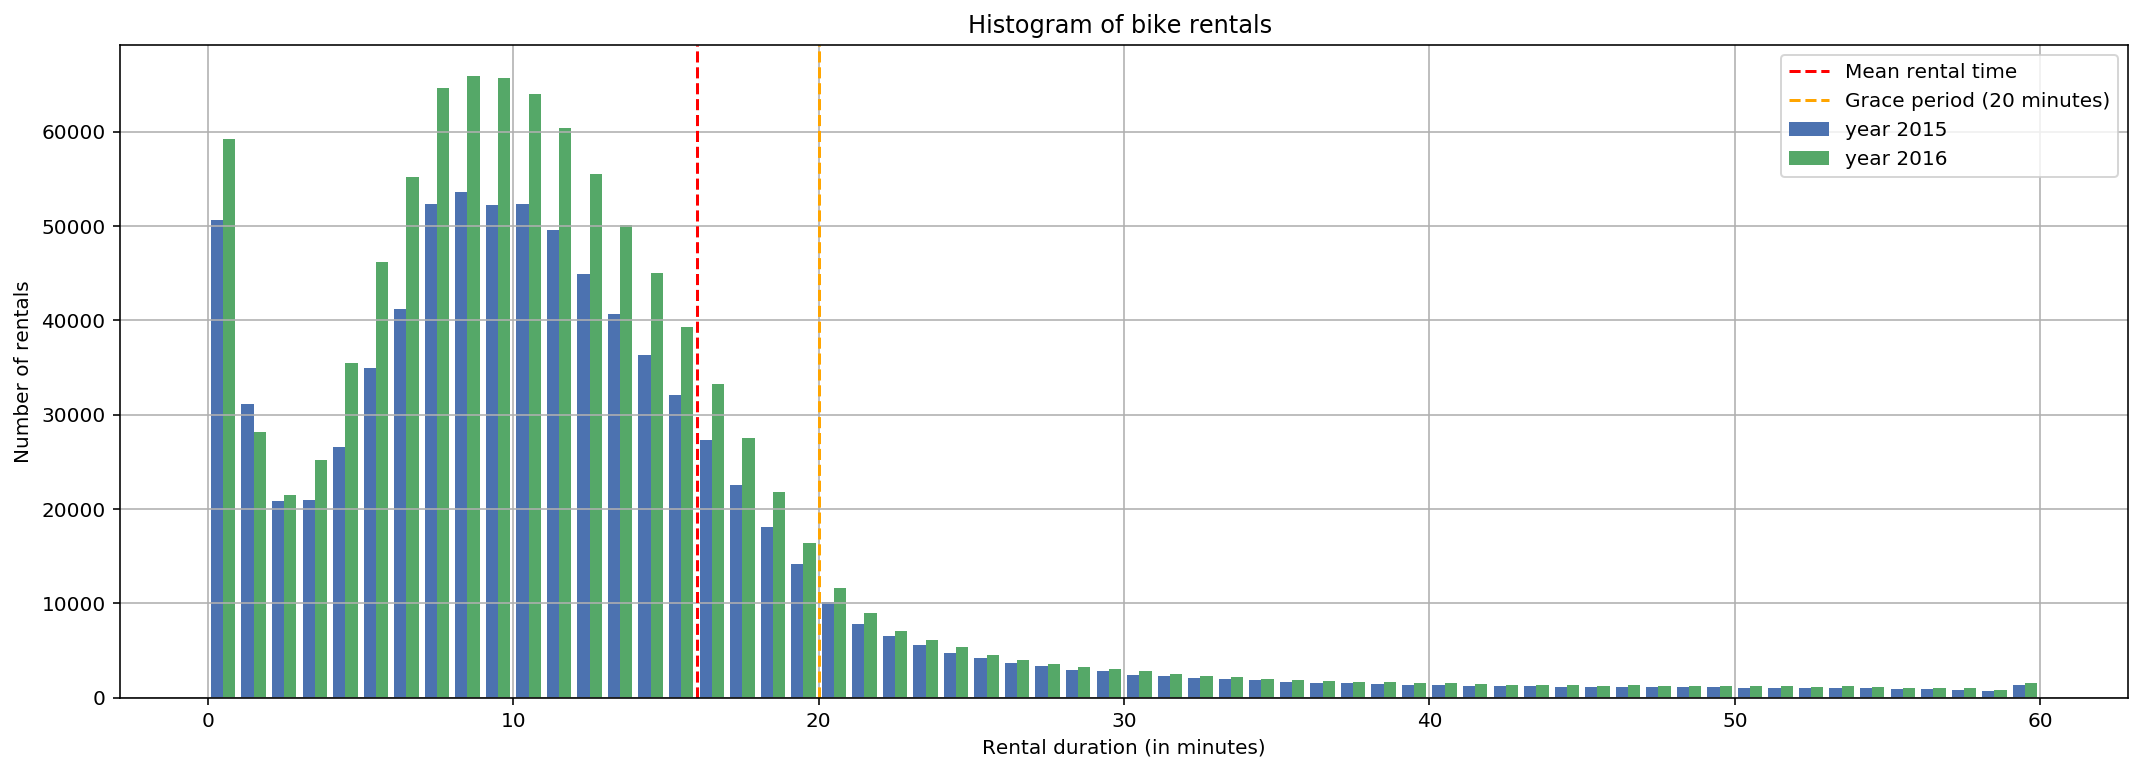

In [28]:
x_2015 = rentals2015_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes
x_2016 = rentals2016_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes

hours_threshold = 1
x_2015_trimmed = x_2015[ np.where(x_2015 <= hours_threshold*60) ] 
x_2016_trimmed = x_2016[ np.where(x_2016 <= hours_threshold*60) ]


plt.figure(figsize=(18,6))
plt.style.use('seaborn-deep')
plt.hist([x_2015_trimmed, x_2016_trimmed], 
         bins=hours_threshold*60, 
         label=['year 2015', 'year 2016']);
plt.axvline(rentals2016_df["Długość wynajmu"].describe()[1].total_seconds() // 60,
           linestyle='dashed',
           color='red',
           label='Mean rental time')

plt.axvline(20,
           linestyle='dashed',
           color='orange',
           label='Grace period (20 minutes)')

plt.title("Histogram of bike rentals ")
plt.xlabel("Rental duration (in minutes)")
plt.ylabel("Number of rentals")
plt.legend()
plt.grid(True)
plt.show()

**DATA INTERPRETATION**
* Average duration for bike rental is approx. 16 minutes, but usually people rent bikes for around 10.5 minutes.
* 85% of all rentals in 2015, and 86% in 2016 were free of charge (85% in 2015, 86% in 2016).

### Rentals made by early adopters

Assumption: Rentals with duration less that 1 minute as considered to be test rides made by early adopters.

In [29]:
test_rentals_2015_idx = rentals2015_df[ (rentals2015_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2015: {} ({:.2f}% of all).'.format(len(test_rentals_2015_idx), len(test_rentals_2015_idx)*100 / total_rentals_2015))

test_rentals_2016_idx = rentals2016_df[ (rentals2016_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2016: {} ({:.2f}% of all).'.format(len(test_rentals_2016_idx), len(test_rentals_2016_idx)*100 / total_rentals_2016))

Number of test rides in 2015: 50655 (6.00% of all).
Number of test rides in 2016: 59278 (5.83% of all).


### Bikes rental over time

In [30]:
# convert data into time series (time as index)
rentals2015_ts = pd.DataFrame(index = rentals2015_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2015_df.shape[0]))
rentals2016_ts = pd.DataFrame(index = rentals2016_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2016_df.shape[0]))

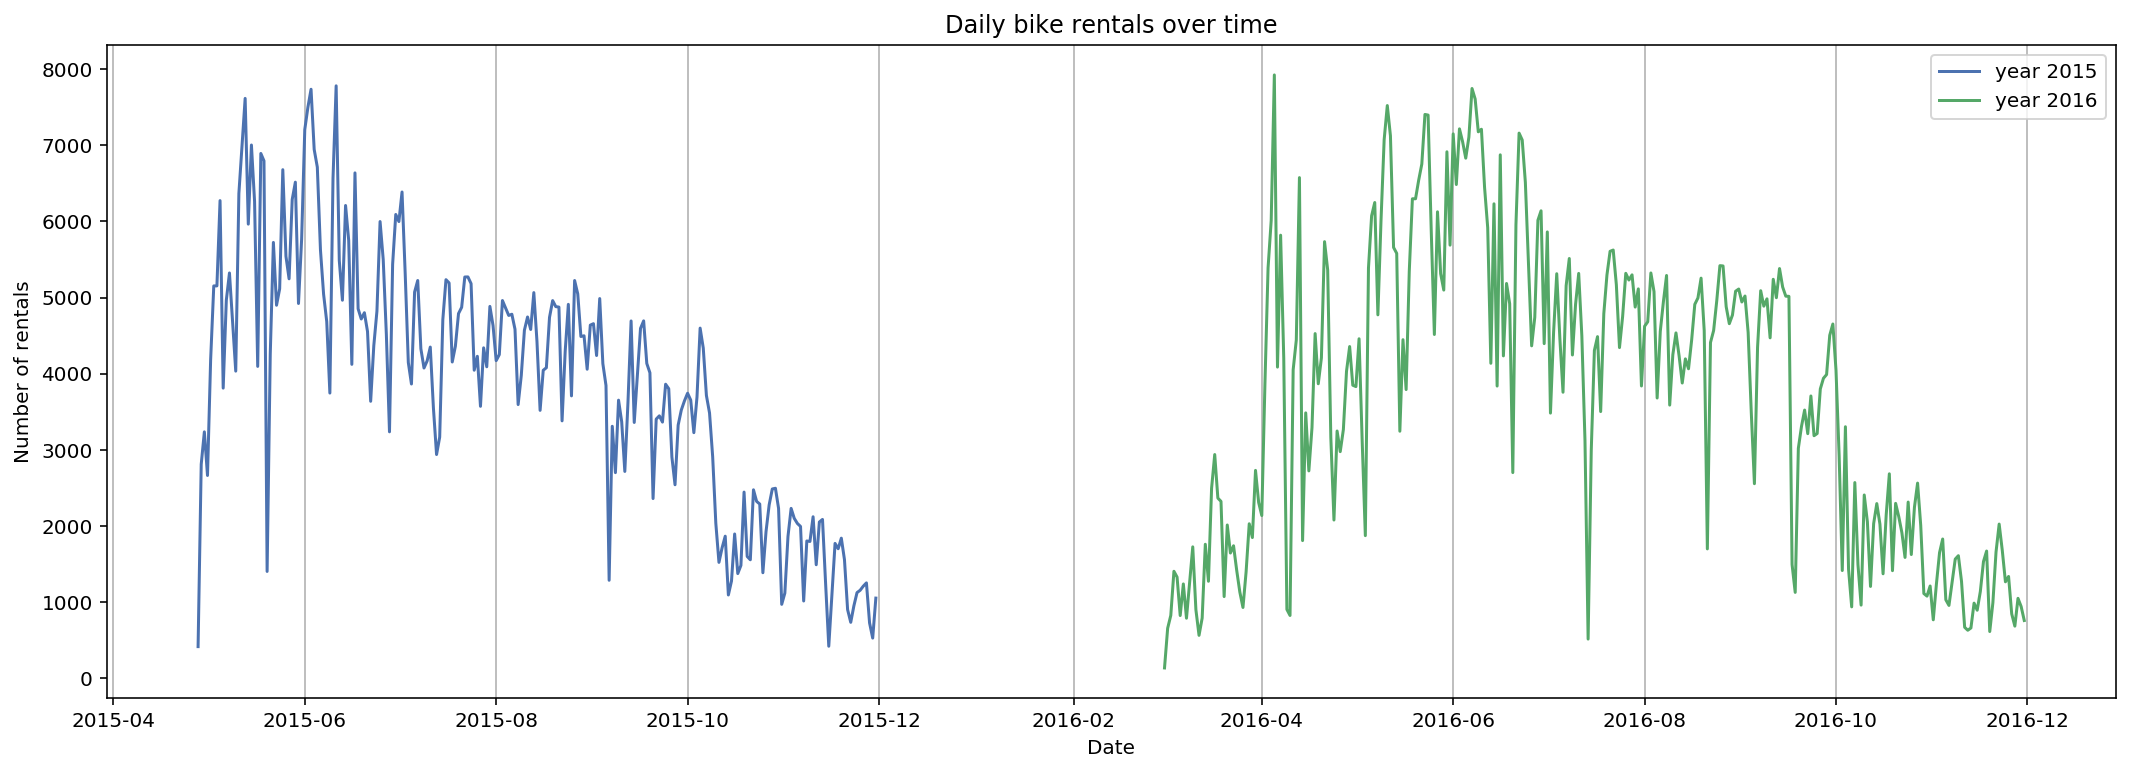

In [31]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rentals2015_ts.resample("D").count(), label='year 2015');
ax.plot(rentals2016_ts.resample("D").count(), label='year 2016')

ax.set_title("Daily bike rentals over time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')

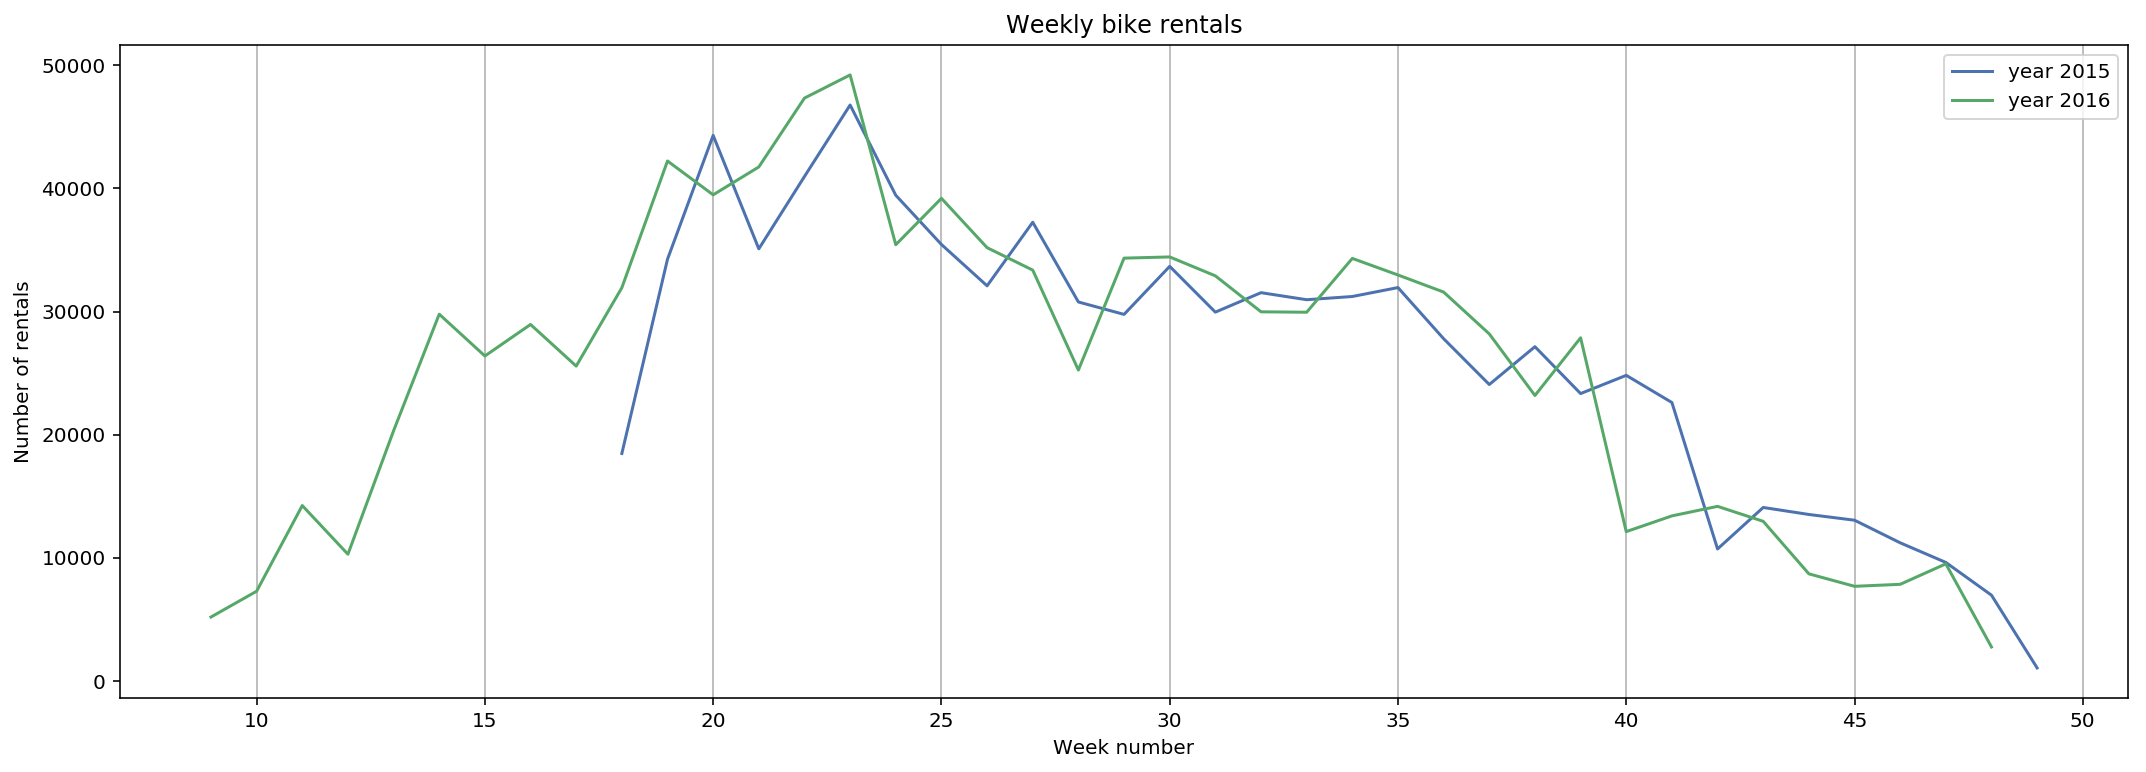

In [32]:
df2015 = rentals2015_ts.resample("W").count()
df2016 = rentals2016_ts.resample("W").count()

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df2015.index.week, df2015["Count"], label='year 2015');
ax.plot(df2016.index.week, df2016["Count"], label='year 2016')

ax.set_title("Weekly bike rentals")
ax.set_xlabel("Week number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')

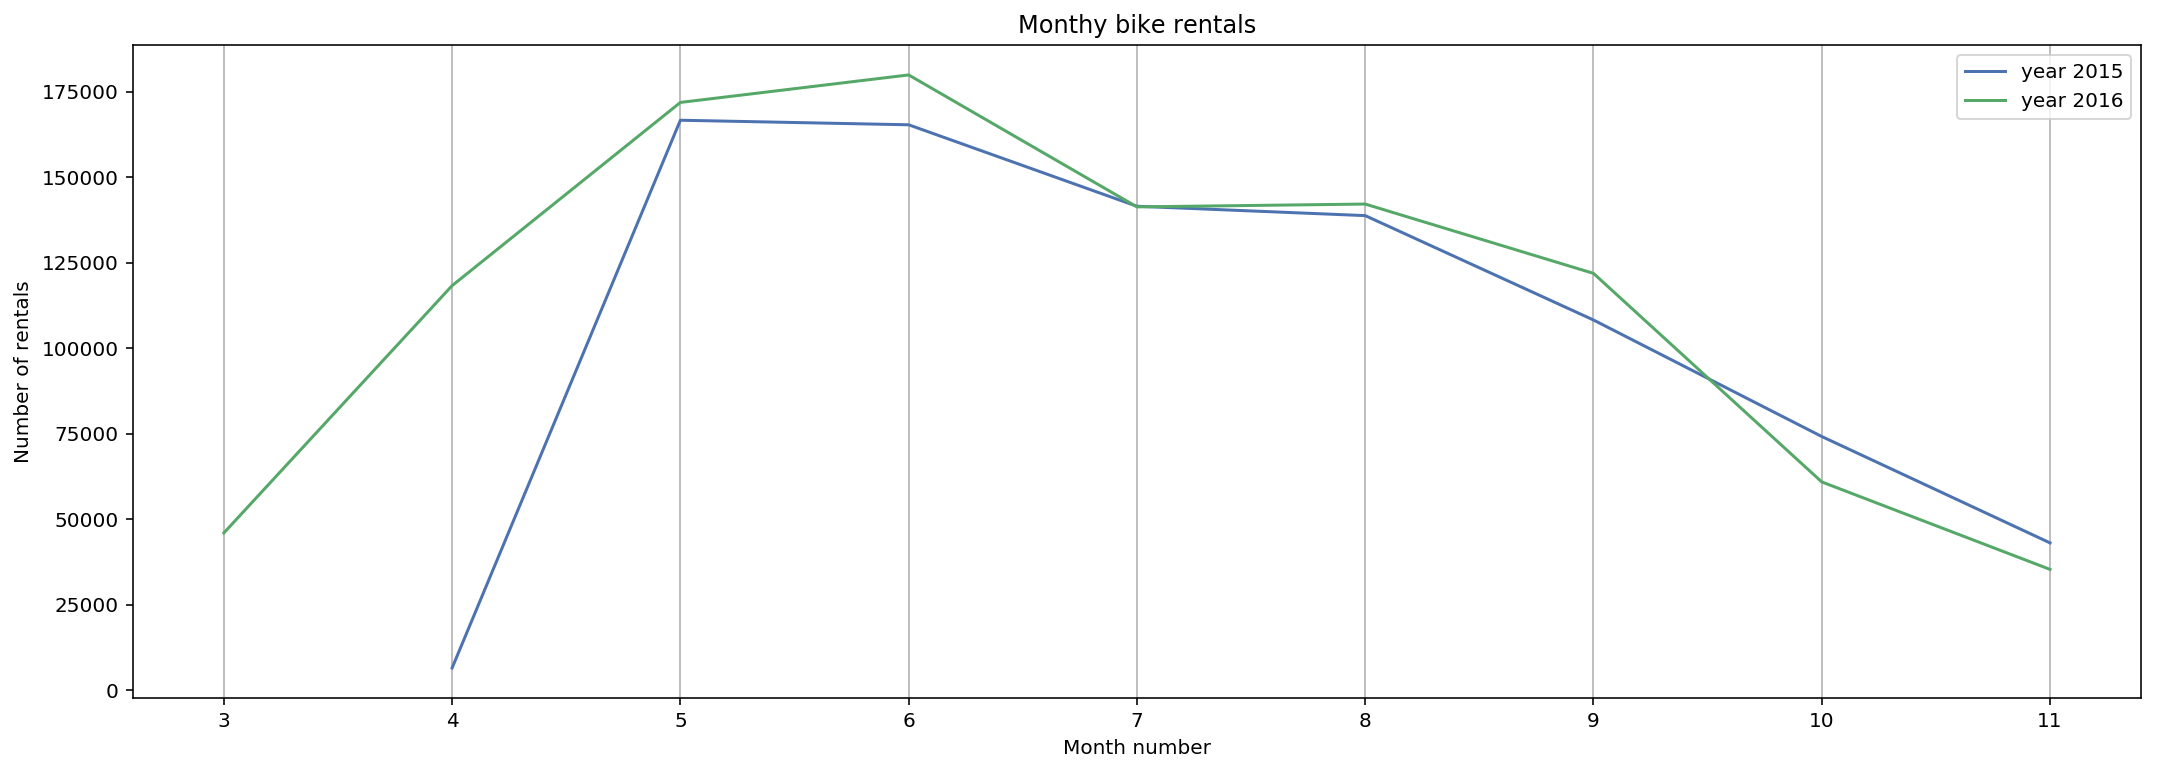

In [33]:
df2015 = rentals2015_ts.resample("M").count()
df2016 = rentals2016_ts.resample("M").count()

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df2015.index.month, df2015["Count"], label='year 2015');
ax.plot(df2016.index.month, df2016["Count"], label='year 2016')

ax.set_title("Monthy bike rentals")
ax.set_xlabel("Month number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')

TODO:
* number of rentals per day/week/month (histogram)
* number of rentals per day of week (histogram)
* number of rentals per hour,
* most popular bike stations for renting bikes
* most popular bike stations for returning bikes
* approx. overall distance travelled by bike
* estimated travel time from one bike station to another.